<a href="https://colab.research.google.com/github/2020147544/Advances_in_Financial_Engineering/blob/main/tb_mlabel_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install cprint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for cprint: filename=cprint-1.2.2-py3-none-any.whl size=2519 sha256=6656927022d8fecd10766deefac7ba3a4a9f51bd0cfed37dae6d19a3531b042b
  Stored in directory: /root/.cache/pip/wheels/e8/c7/77/b74864ee8de3abb693e3be291549a29c6ff242ce66801b1622
Successfully built cprint


In [2]:
#Import and Settings
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from collections import deque
from itertools import accumulate
from cprint import *
import bisect
import warnings

plt.rcParams['figure.figsize'] = 17,9
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# 0. 데이터
kq150_data = pd.read_csv(r'C:\Users\John\OneDrive\바탕 화면\School\24Spring\수프밍\project\data\KQ150.csv',index_col=0)
# kq150_dollar = pd.read_csv(r'Kp200F_volume_bars_500.csv',index_col=0)
kq150_data.index = pd.to_datetime(kq150_data.index)
# kq150_dollar.index = pd.to_datetime(kq150_dollar.index)

In [11]:
kq150_data.head()

,Open,High,Low,Close
Date-Time,,,,
2016-01-04 10:00:00,1090.0,1092.0,1090.0,1092.0
2016-01-04 10:01:00,1092.0,1093.0,1092.0,1093.0
2016-01-04 10:02:00,1093.0,1093.0,1093.0,1093.0
2016-01-04 10:03:00,1093.0,1093.0,1093.0,1093.0
2016-01-04 10:04:00,1092.7,1092.7,1092.5,1092.5


In [4]:
kq150_data.index

DatetimeIndex(['2016-01-04 10:00:00', '2016-01-04 10:01:00',
               '2016-01-04 10:02:00', '2016-01-04 10:03:00',
               '2016-01-04 10:04:00', '2016-01-04 10:05:00',
               '2016-01-04 10:06:00', '2016-01-04 10:07:00',
               '2016-01-04 10:09:00', '2016-01-04 10:11:00',
               ...
               '2023-04-25 15:26:00', '2023-04-25 15:27:00',
               '2023-04-25 15:28:00', '2023-04-25 15:29:00',
               '2023-04-25 15:30:00', '2023-04-25 15:31:00',
               '2023-04-25 15:32:00', '2023-04-25 15:33:00',
               '2023-04-25 15:34:00', '2023-04-25 15:45:00'],
              dtype='datetime64[ns]', name='Date-Time', length=654558, freq=None)

# Tripple Barrier

In [5]:
# 1. 파킨슨 변동성
def parkinson_volatility(df, n):
    data_scope = deque()
    date = df.index
    parkinson_vol_lst = []
    for i in range(len(df)):
        data_scope.append(df.iloc[i, :])
        if len(data_scope) > n:
            data_scope.popleft()

        parkinson_vol = np.sqrt(
            sum(np.log(pd.DataFrame(data_scope)['High'].values / pd.DataFrame(data_scope)['Low'].values) ** 2) / (
                        4 * np.log(2) * n))
        parkinson_vol_lst.append(parkinson_vol)
    
    parkinson_vol_df = pd.DataFrame(data=parkinson_vol_lst, index=date, columns=['parksinson_vol'])
    return parkinson_vol_df

In [6]:
def getDailyVol(close,span0=100):
    '''
    daily vol, reindexed to close
    - used to set default profit taking and stop-loss limits
    '''
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]
    df0=pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily returns
    df0=df0.ewm(span=span0).std()
    return df0


In [7]:
parkinson_vol = parkinson_volatility(kq150_data,10)
parkinson_vol, parkinson_vol.mean()

(                     parksinson_vol
 Date-Time                          
 2016-01-04 10:00:00        0.000348
 2016-01-04 10:01:00        0.000389
 2016-01-04 10:02:00        0.000389
 2016-01-04 10:03:00        0.000389
 2016-01-04 10:04:00        0.000391
 ...                             ...
 2023-04-25 15:31:00        0.000610
 2023-04-25 15:32:00        0.000603
 2023-04-25 15:33:00        0.000599
 2023-04-25 15:34:00        0.000625
 2023-04-25 15:45:00        0.000575
 
 [654558 rows x 1 columns],
 parksinson_vol    0.000505
 dtype: float64)

In [8]:
entrance_exit_in = pd.read_csv(r'C:\Users\John\OneDrive\바탕 화면\School\24Spring\수프밍\project\data\entrance_exit_in.csv',index_col=0)

In [9]:
entrance = pd.to_datetime(entrance_exit_in['Entrance'])
entrance = pd.to_datetime(entrance.values)
exit_ = pd.to_datetime(entrance_exit_in['Clearing'])
exit_ = pd.to_datetime(exit_.values)

In [10]:
entrance

DatetimeIndex(['2018-01-03 14:07:00', '2018-01-03 14:53:00',
               '2018-01-04 09:20:00', '2018-01-04 11:12:00',
               '2018-01-04 15:19:00', '2018-01-05 10:14:00',
               '2018-01-05 13:31:00', '2018-01-08 13:39:00',
               '2018-01-09 09:59:00', '2018-01-09 11:41:00',
               ...
               '2021-11-03 11:11:00', '2021-11-04 10:34:00',
               '2021-11-05 10:12:00', '2021-11-08 09:37:00',
               '2021-11-08 10:03:00', '2021-11-09 09:28:00',
               '2021-11-09 10:10:00', '2021-11-10 10:15:00',
               '2021-11-11 10:02:00', '2021-11-11 10:23:00'],
              dtype='datetime64[ns]', length=1398, freq=None)

In [12]:
exit_

DatetimeIndex(['2018-01-03 14:10:00', '2018-01-03 14:56:00',
               '2018-01-04 09:23:00', '2018-01-04 11:15:00',
               '2018-01-04 15:22:00', '2018-01-05 10:17:00',
               '2018-01-05 13:34:00', '2018-01-08 13:41:00',
               '2018-01-09 10:02:00', '2018-01-09 11:44:00',
               ...
               '2021-11-03 11:14:00', '2021-11-04 10:37:00',
               '2021-11-05 10:15:00', '2021-11-08 09:40:00',
               '2021-11-08 10:06:00', '2021-11-09 09:31:00',
               '2021-11-09 10:13:00', '2021-11-10 10:18:00',
               '2021-11-11 10:05:00', '2021-11-11 10:26:00'],
              dtype='datetime64[ns]', length=1398, freq=None)

In [14]:
kq150_data['side'] = np.NaN

In [15]:
kq150_data.head()

,Open,High,Low,Close,side
Date-Time,,,,,
2016-01-04 10:00:00,1090.0,1092.0,1090.0,1092.0,NaN
2016-01-04 10:01:00,1092.0,1093.0,1092.0,1093.0,NaN
2016-01-04 10:02:00,1093.0,1093.0,1093.0,1093.0,NaN
2016-01-04 10:03:00,1093.0,1093.0,1093.0,1093.0,NaN
2016-01-04 10:04:00,1092.7,1092.7,1092.5,1092.5,NaN


In [16]:
kq150_data.index[0]

Timestamp('2016-01-04 10:00:00')

In [17]:
for idx in range(120000,len(kq150_data.index)):
    if kq150_data.index[idx] in entrance:
        kq150_data['side'][idx] = 1
        # print(idx)
    if kq150_data.index[idx] in exit_:
        kq150_data['side'][idx] = -1
        # print(idx)

In [18]:
kq150_data['side'][374267]

1.0

In [19]:
kq150_data.head()

,Open,High,Low,Close,side
Date-Time,,,,,
2016-01-04 10:00:00,1090.0,1092.0,1090.0,1092.0,NaN
2016-01-04 10:01:00,1092.0,1093.0,1092.0,1093.0,NaN
2016-01-04 10:02:00,1093.0,1093.0,1093.0,1093.0,NaN
2016-01-04 10:03:00,1093.0,1093.0,1093.0,1093.0,NaN
2016-01-04 10:04:00,1092.7,1092.7,1092.5,1092.5,NaN


In [20]:
# 2. CS_filter
def getTEvents(gRaw,h): #gRaw: dollar['Close'], h:d_vol.mean()
    tEvents,sPos,sNeg=[],0,0
    diff=gRaw.diff()
    h = float(h)
    for i in diff.index[1:]:
        sPos,sNeg=float(max(0,sPos+diff.loc[i])),float(min(0,sNeg+diff.loc[i]))
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

In [21]:
tEvents = getTEvents(kq150_data['Close'], parkinson_vol.mean())
tEvents

DatetimeIndex(['2016-01-04 10:01:00', '2016-01-04 10:04:00',
               '2016-01-04 10:05:00', '2016-01-04 10:06:00',
               '2016-01-04 10:07:00', '2016-01-04 10:09:00',
               '2016-01-04 10:11:00', '2016-01-04 10:16:00',
               '2016-01-04 10:18:00', '2016-01-04 10:19:00',
               ...
               '2023-04-25 15:26:00', '2023-04-25 15:27:00',
               '2023-04-25 15:28:00', '2023-04-25 15:29:00',
               '2023-04-25 15:30:00', '2023-04-25 15:31:00',
               '2023-04-25 15:32:00', '2023-04-25 15:33:00',
               '2023-04-25 15:34:00', '2023-04-25 15:45:00'],
              dtype='datetime64[ns]', length=589081, freq=None)

In [22]:
# 3. Tripple Barrier Labeling
def applyPtSlOnT1(close,events,ptSl,molecule):
    
    '''
    Tripple-barrier labeling method
    ` Apply stop loss/profit taking, if it takes place before t1 (end of event)

    Input: 
    ` events: 
      — t1: the timestamp of vertical barrier
      — trgt: the unit width of the horizontal barriers, expressed in terms of absolute returns
    ` ptsl: a list of two non-negative float values
      - ptsl[0]: the factor multiplies trgt to set the width of the upper barrier
      - ptsl[1]: the factor that multiplies trgt to set the width of the lower barrier
    ` molecule: a list with the subset of event indices 

    Output: a Dataframe containing the timestamps at which each barrier was touched, [pt, s1, t1]
    ` 0 (inactive barrier) or 1 (active barrier)

    '''
    #events_=events.loc[molecule]
    events_=events
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0:pt=ptSl[0]*events_['trgt']
    else:pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0:sl=-ptSl[1]*events_['trgt']
    else:sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events_['t1'].fillna(close.index[-1]).items():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss.
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking.
    return out


# MultiProcessing

In [23]:
# 20.4.1 - mpPandasObj
def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    print(parts)
    return parts

In [24]:
# 20.4.1 - mpPandasObj
def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    print("nestedParts: ", len(parts))
    return parts

In [25]:
# 20.10
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    print("ExpandCall: ", len(out))
    return out

In [26]:
# 20.8 - mpPandasObj
def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    print("processJobs_: ", len(out))
    return out

In [27]:
# 4. Multiprocessing Obj
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)
    
    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    print("jobs: ", len(jobs))
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=pd.concat([df0,i]) #df0=df0.append(i)
    df0=df0.sort_index()
    return df0

# Meta Labeling

In [28]:
# 5. Get the First Time of Touch
def getEvents(close,tEvents,ptSl,trgt,minRet,numThreads,t1=False,side=None):
    '''
    Getting the time of first touch
     
    Input:
    ` tEvents: the pandas timeindex containing the timestamps that will seed every triple barrier 
      - the timestamps selected by the sampling procedures 
    ` minRet: the minimum target return required for running a triple barrier search
    ` numThreads: the number of threads concurrently used by the function  

    Output: 
    ` events: a Dataframe
      - events.index: event's starttime
      - events['t1']: event's endtime
      - events['trgt']: event's target
      - events['side'] (optional): the algo's position side
    '''
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    print(trgt.index)
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT,index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptSl_=pd.Series(1.,index=trgt.index),[ptSl[0],ptSl[0]]
    else:side_,ptSl_=side.loc[trgt.index],ptSl[:2]
    events=pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1).droplevel(1, axis=1).dropna(subset=['trgt'])
    # print(events.index)
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index), numThreads=numThreads,close=close,events=events,ptSl=ptSl_)
    # print("event['t1']: ", events['t1'])
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events


In [29]:
#Vertical Barrier
def addVerticalBarrier(close, events, numDays=1):
    t1=close.index.searchsorted(events+pd.Timedelta(days=numDays))
    t1=t1[t1<close.shape[0]]
    t1=pd.Series(close.index[t1],index=events[:t1.shape[0]]) # NaNs at end
    return t1

In [30]:
t1 = addVerticalBarrier(kq150_data['Close'], tEvents, 1)
t1

2016-01-04 10:01:00   2016-01-05 10:01:00
2016-01-04 10:04:00   2016-01-05 10:04:00
2016-01-04 10:05:00   2016-01-05 10:05:00
2016-01-04 10:06:00   2016-01-05 10:06:00
2016-01-04 10:07:00   2016-01-05 10:07:00
                              ...        
2023-04-24 15:31:00   2023-04-25 15:31:00
2023-04-24 15:32:00   2023-04-25 15:32:00
2023-04-24 15:33:00   2023-04-25 15:33:00
2023-04-24 15:34:00   2023-04-25 15:34:00
2023-04-24 15:45:00   2023-04-25 15:45:00
Name: Date-Time, Length: 588703, dtype: datetime64[ns]

In [31]:
# create target series
ptsl = [1,1]
target=parkinson_vol
# select minRet
minRet = 0.000505

# Run in single-threaded mode on Windows
from multiprocessing import cpu_count
import platform
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1


In [32]:
events = getEvents(kq150_data['Close'],tEvents,ptsl,target,minRet,cpus,t1=t1, side=kq150_data['side'])

# 최종적인 Tripple Barrier Output
events.head()

DatetimeIndex(['2016-01-04 10:01:00', '2016-01-04 10:04:00',
               '2016-01-04 10:05:00', '2016-01-04 10:06:00',
               '2016-01-04 10:07:00', '2016-01-04 10:09:00',
               '2016-01-04 10:11:00', '2016-01-04 10:16:00',
               '2016-01-04 10:18:00', '2016-01-04 10:19:00',
               ...
               '2023-04-25 15:26:00', '2023-04-25 15:27:00',
               '2023-04-25 15:28:00', '2023-04-25 15:29:00',
               '2023-04-25 15:30:00', '2023-04-25 15:31:00',
               '2023-04-25 15:32:00', '2023-04-25 15:33:00',
               '2023-04-25 15:34:00', '2023-04-25 15:45:00'],
              dtype='datetime64[ns]', length=589081, freq=None)
[     0 236973]
jobs:  1
ExpandCall:  236973
processJobs_:  1


,t1,trgt,side
2016-01-04 11:09:00,2016-01-05 11:09:00,0.000548,NaN
2016-01-04 11:10:00,2016-01-05 11:10:00,0.000699,NaN
2016-01-04 11:11:00,2016-01-05 11:11:00,0.000698,NaN
2016-01-04 11:12:00,2016-01-05 11:12:00,0.000698,NaN
2016-01-04 11:13:00,2016-01-05 11:13:00,0.000698,NaN


In [38]:
#events.to_csv('tri_barrier.csv')

### Meta-labeling

In [39]:
def getBins(events,close,t1):
    '''
    Labeling for side and size
    Input:
    ` events: a Dataframe
      - events.index: event's startime
      - events['t1']: event's endtime
      - events['trgt']: target
      - events['side']: algo's position side (optional)
    `t1: original vertical barrier
         
    Output:
    ` ret: the return realized at the time of the first touched barrier
    ` bin: the label as a function of the sign of the outcome 
      - Case 1: ('side' not in events): bin in (-1,1) <- label by price action (standard labeling)
      - Case 2: ('side' in events): bin in (0,1), i.e. pass or bet <- label by pnl (meta-labeling) 
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')

    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:
        out['ret'] *= events_['side']
    out['bin']=np.sign(out['ret'])  # -1, 0, 1 value return

    if 'side' in events_:
        out.loc[out['ret']<=0, 'bin'] = 0 # meta-labeling
    else: 
        # update binary->0 when vertical barrier is touched
        # when not meta-labeling
        ver_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[ver_first_idx, 'bin'] = 0

    return out


In [34]:
def dropLabels(events,minPct=.05):
    '''
    Apply weights, drop labels with insufficient examples

    '''
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3: break
        print('dropped label',df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

In [35]:
# triple barrier을 통해 얻은 event값을 넣어 meta-labeling
m_events = getBins(events, kq150_data['Close'], t1)  # t1=vertical barrier
m_label = dropLabels(m_events, minPct=.05)  # to get meta label

m_label

,ret,bin
2016-01-04 11:09:00,NaN,NaN
2016-01-04 11:10:00,NaN,NaN
2016-01-04 11:11:00,NaN,NaN
2016-01-04 11:12:00,NaN,NaN
2016-01-04 11:13:00,NaN,NaN
...,...,...
2023-04-24 15:22:00,NaN,NaN
2023-04-24 15:30:00,NaN,NaN
2023-04-24 15:31:00,NaN,NaN
2023-04-24 15:32:00,NaN,NaN


In [40]:
m_label.to_csv('m_label.csv')

In [41]:
m_label['bin'].value_counts(normalize=True)

bin
1.0    0.544037
0.0    0.455963
Name: proportion, dtype: float64

In [42]:
len(m_label)

236668

In [43]:
m_label = m_label[(m_label['bin'] == 0) | (m_label['bin'] == 1)]

In [44]:
m_label

,ret,bin
2018-01-03 14:07:00,0.002068,1.0
2018-01-03 14:10:00,-0.002959,0.0
2018-01-03 14:53:00,0.000960,1.0
2018-01-03 14:56:00,0.001917,1.0
2018-01-04 09:20:00,0.003356,1.0
...,...,...
2021-11-10 10:18:00,0.001505,1.0
2021-11-11 10:02:00,-0.000969,0.0
2021-11-11 10:05:00,0.001456,1.0
2021-11-11 10:23:00,-0.001253,0.0


In [45]:
m_label.index

DatetimeIndex(['2018-01-03 14:07:00', '2018-01-03 14:10:00',
               '2018-01-03 14:53:00', '2018-01-03 14:56:00',
               '2018-01-04 09:20:00', '2018-01-04 09:23:00',
               '2018-01-04 11:12:00', '2018-01-04 11:15:00',
               '2018-01-04 15:19:00', '2018-01-04 15:22:00',
               ...
               '2021-11-09 09:28:00', '2021-11-09 09:31:00',
               '2021-11-09 10:10:00', '2021-11-09 10:13:00',
               '2021-11-10 10:15:00', '2021-11-10 10:18:00',
               '2021-11-11 10:02:00', '2021-11-11 10:05:00',
               '2021-11-11 10:23:00', '2021-11-11 10:26:00'],
              dtype='datetime64[ns]', length=2566, freq=None)

### Ensemble Method

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

In [47]:
max_depth = 3
n_estimators = 1000

# set randomforest model
rf = RandomForestClassifier(
    max_depth=max_depth,
    n_estimators=n_estimators,
    criterion='entropy',
    class_weight=None,
    random_state=101
)

In [48]:
# seperate train/test data
X = kq150_data.reindex(m_label.index)
y = m_label['bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [49]:
# train
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=1000,
                       random_state=101)

              precision    recall  f1-score   support

         0.0       0.51      0.51      0.51       344
         1.0       0.61      0.61      0.61       426

    accuracy                           0.56       770
   macro avg       0.56      0.56      0.56       770
weighted avg       0.57      0.56      0.56       770



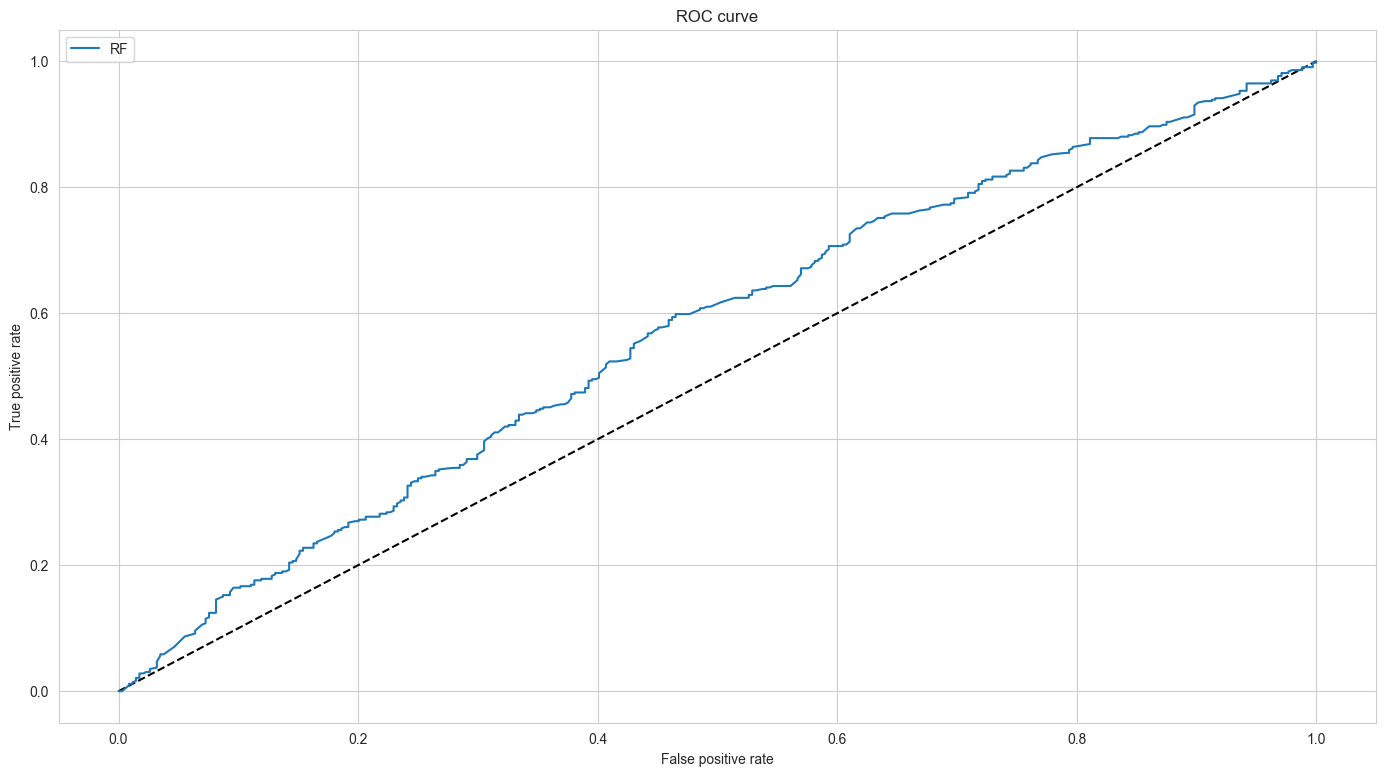

In [50]:
# predict
y_prob = rf.predict_proba(X_test)[:, 1]
# print(y_prob)
y_pred = rf.predict(X_test)
# print(y_pred)

rFP, rTP, thresholds = roc_curve(y_test, y_prob)
print(classification_report(y_test, y_pred))
      
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rFP, rTP, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()